TACOTRON

In [2]:
from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import nd, autograd
from IPython.display import clear_output
ctx= mx.cpu()

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def get_spectrograms(sound_file): 
    '''Extracts melspectrogram and log magnitude from given `sound_file`.
    Args:
      sound_file: A string. Full path of a sound file.

    Returns:
      Transposed S: A 2d array. A transposed melspectrogram with shape of (T, n_mels)
      Transposed magnitude: A 2d array.Has shape of (T, 1+hp.n_fft//2)
    '''
    frame_shift = 0.0125
    frame_length = 0.05
    
    # Loading sound file
    y, sr = librosa.load(sound_file) # or set sr to hp.sr.
    print("Sampling at "+str(sr))
    # stft. D: (1+n_fft//2, T)
    D = librosa.stft(y=y,
                     n_fft=2048, 
                     hop_length=int(sr*frame_shift), 
                     win_length=int(sr*frame_length)
                    ) 
    
    # magnitude spectrogram
    magnitude = np.abs(D) #(1+n_fft/2, T)
    
    log_magnitude=librosa.amplitude_to_db(magnitude,ref=np.max)
    
    # mel spectrogram
    S = librosa.feature.melspectrogram(S=log_magnitude, n_mels=80) #(n_mels, T)
    return S
    #return np.transpose(S.astype(np.float32)), np.transpose(magnitude.astype(np.float32)) # (T, n_mels), (T, 1+n_fft/2)


In [4]:
S=get_spectrograms('train_data/7_jackson_33.wav')

Sampling at 22050


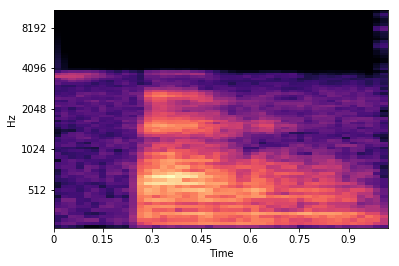

In [5]:
%matplotlib inline
librosa.display.specshow(S,y_axis='mel',x_axis='time')

In [6]:
num_hidden = 256
reduction_factor=2
emb_size=256
batch_size=10

In [14]:
import csv
import codecs
import re


def generate_vocabulary(texts_list):    
    # get unique chars and put into a list
    return list(set(''.join(texts_list)))
    

def generate_chars2numbers_mappings(vocabulary):
    # create a chars <-> numbers mappings
    char2index = {char:i for i,char in enumerate(vocabulary)}
    index2char = {i:char for i,char in enumerate(vocabulary)}
    
    return char2index,index2char


def text2numbers(texts_list,char2index_mapping):
    numerical_texts=[]
    for text in texts_list:
        numerical_texts.append([char2index_mapping[char] for char in text])
    return numerical_texts

def open_data(input_file_path):
      
    texts, sound_files = [], []
    
    reader = csv.reader(codecs.open(input_file_path, 'rb', 'utf-8'))
    for row in reader:
        sound_filename, text = row
        sound_file = "train_data/" + sound_filename + ".wav"
        text = re.sub(r"[^ a-z']", "", text.strip().lower())
         
        texts.append(text)
        sound_files.append(sound_file)
             
    return texts, sound_files

def generate_train_eval_data(text_trainset, sound_labels):
    size=len(text_trainset)

    vocabulary = generate_vocabulary(texts_list)
    vocab_size=len(vocabulary)
    char2index,index2char = generate_chars2numbers_mappings(vocabulary)

    texts_numerical = text2numbers(texts_list,char2index)
    #texts_one_hot=[mx.ndarray.one_hot(mx.nd.array(text_numerical),vocab_size) for text_numerical in texts_numerical]

    train_data = []
    train_label = []
    eval_data = []
    eval_label = []
 
    # get 10% of dataset as eval data
    random_samples = np.random.randint(size, size=size//10)
    
    for i in range(size):
        try:
            if i in random_samples:
                eval_data.append(texts_numerical[i])
                eval_label.append(sound_labels[i])
            else:
                train_data.append(texts_numerical[i])
                train_label.append(sound_labels[i])
        except IndexError as e:
            print(e)
            print("i=%s, thing to add: %s %s"%(i,text_trainset[i],sound_labels[i]))

    with open('train_data/train_data.csv', 'w') as csvfile:
        for line in train_data:
            csvfile.write(','.join(str(char) for char in line)+"\n")
    
    with open('train_data/train_label.csv', 'w') as csvfile:
        for line in train_label:
            csvfile.write(','.join(str(char) for char in line)+"\n")
    
    with open('train_data/eval_data.csv', 'w') as csvfile:
        for line in eval_data:
            csvfile.write(','.join(str(char) for char in line)+"\n")
    
    with open('train_data/eval_label.csv', 'w') as csvfile:
        for line in eval_label:
            csvfile.write(','.join(str(char) for char in line)+"\n")

    
    traindata_iterator = mx.io.NDArrayIter(data={'data':train_data},
                                label={'mel':mx.nd.ones((240,1))},
                                batch_size=batch_size)
    evaldata_iterator = mx.io.NDArrayIter(data={'data':eval_data},
                                label={'mel':mx.nd.ones((240,1))},
                                batch_size=batch_size)
    
    return traindata_iterator, evaldata_iterator


texts_list, sound_files_list = open_data('train_data/dataset.csv')
size=len(sound_files_list)

longest_word = 0
for text in texts_list:
    longest_word = max(longest_word,len(text))

traindata_iterator, evaldata_iterator = generate_train_eval_data(texts_list, sound_files_list)

vocabulary = generate_vocabulary(texts_list)
vocab_size=len(vocabulary)
char2index,index2char = generate_chars2numbers_mappings(vocabulary)

#texts_numerical = text2numbers(texts_list,char2index)

#texts_one_hot=[mx.ndarray.one_hot(mx.nd.array(text_numerical),vocab_size) for text_numerical in texts_numerical]

#dummy_sound=mx.nd.arange(200)

#sounds_one_hot=mx.nd.one_hot(dummy_sound,200)

In [15]:
"""
FC-256-ReLU → Dropout(0.5) → FC-128-ReLU → Dropout(0.5)
"""
def prenet_pass(data):
    fc1 = mx.symbol.FullyConnected(data=data, num_hidden=emb_size, name='prenet_fc1')
    act1 = mx.symbol.Activation(data=fc1, act_type='relu', name='prenet_act1')
    drop1 = mx.symbol.Dropout(act1, p=0.5, name='prenet_drop1')
    
    fc2 = mx.symbol.FullyConnected(data=drop1, num_hidden=emb_size//2, name='prenet_fc2')
    act2 = mx.symbol.Activation(data=fc2, act_type='relu', name='prenet_act2')
    prenet_output = mx.symbol.Dropout(act2, p=0.5, name='prenet_drop2')
    
    return prenet_output

In [16]:
# banco di filtri convolutivi. Vengono creati K filtri con kernel 1D di dimensione:k 
def conv1dBank(conv_input, K):
    conv=mx.sym.Convolution(data=conv_input, kernel=(1,1), num_filter=emb_size//2)
    (conv, mean, var) = mx.sym.BatchNorm(data=conv, output_mean_var=True)
    conv = mx.sym.Activation(data=conv, act_type='relu')
    for k in range(2, K+1):
        convi = mx.sym.Convolution(data=conv_input, kernel=(k,1), num_filter=emb_size//2)
        (convi, mean, var) = mx.sym.BatchNorm(data=convi, output_mean_var=True)
        convi = mx.sym.Activation(data=convi, act_type='relu')
        conv = mx.symbol.concat(conv,convi)
    return conv

In [17]:
# highway
def highway_layer(data):
    H= mx.symbol.Activation(
        data=mx.symbol.FullyConnected(data=data, num_hidden=emb_size//2, name="highway_fcH"),
        act_type="relu"
    )
    T= mx.symbol.Activation(
        data=mx.symbol.FullyConnected(data=data, num_hidden=emb_size//2, bias=mx.sym.Variable('bias'), name="highway_fcT"),
        act_type="sigmoid"
    )
    return  H * T + data * (1.0 - T)


In [18]:
# CBHG
def CBHG(data,K,proj1_size,proj2_size):
    #se si usa infer_shape su convbank dando la dimensione dell'input, viene dedotta la shape appunto 
    bank = conv1dBank(data,K)
    poold_bank = mx.sym.Pooling(data=bank, pool_type='max', kernel=(2, 1), stride=(1,1), name="CBHG_pool")

    proj1 = mx.sym.Convolution(data=poold_bank, kernel=(3,1), num_filter=proj1_size, name='CBHG_conv1')
    (proj1, proj1_mean, proj1_var) = mx.sym.BatchNorm(data=proj1, output_mean_var=True, name='CBHG_batch1')
    proj1 = mx.sym.Activation(data=proj1, act_type='relu', name='CBHG_act1')

    proj2 = mx.sym.Convolution(proj1, kernel=(3,1), num_filter=proj2_size, name='CBHG_conv2')
    (proj2, proj2_mean, proj2_var) = mx.sym.BatchNorm(data=proj2, output_mean_var=True, name='CBHG_batch2')
    
    residual= proj2 + data

    for i in range(4):
        residual = highway_layer(residual)
    highway_pass = residual
   
    bidirectional_gru_cell = mx.rnn.BidirectionalCell(
        mx.rnn.GRUCell(num_hidden=emb_size//2, prefix='CBHG_gru1'),
        mx.rnn.GRUCell(num_hidden=emb_size//2, prefix='CBHG_gru2')
    )
    outputs, states = bidirectional_gru_cell.unroll(1, inputs=highway_pass, merge_outputs=True)
    return outputs

In [19]:
# encoder
def encoder(data):
    embed_vector = mx.sym.Embedding(data=data, input_dim=longest_word, output_dim=emb_size, name='encoder_embed')
    prenet_output = prenet_pass(embed_vector)
    return CBHG(prenet_output,16, emb_size//2, emb_size//2)

In [20]:
text = mx.sym.Variable('text')

encoded = encoder(text)
graph=mx.viz.plot_network(
    encoded,
    save_format='pdf',
    title='encoder')
#graph.render()

In [21]:
# decoder
def decoder(input_spectrogram,context,reduction_factor):
    #embed_vector = mx.sym.Embedding(data=input_spectrogram, input_dim=80, output_dim=emb_size, name='decoder_embed')
    prenet_output = prenet_pass(input_spectrogram)
        
    stack = mx.rnn.SequentialRNNCell()
    stack.add(mx.rnn.GRUCell(num_hidden=emb_size,prefix='decoder_layer1_'))
    stack.add(mx.rnn.GRUCell(num_hidden=emb_size,prefix='decoder_layer2_'))
    
    residual_gru_stack = mx.rnn.ResidualCell(stack)
    
    gru_outputs,states = residual_gru_stack.unroll(length=1,
                                               inputs=prenet_output,
                                               begin_state=context,
                                               merge_outputs=True)

    predicted_frames = mx.symbol.Activation(
        data=mx.symbol.FullyConnected(data=gru_outputs, num_hidden=80*reduction_factor),
        act_type="relu"
    )
    
    return predicted_frames, states

In [22]:
spectrogram = mx.sym.Variable('spectrogram')
spectrograms_count=5 #dummy value
decoder_state=[encoded,encoded]
predicted_frames=spectrogram
full_frame=mx.sym.Variable('go')

for i in range(spectrograms_count):
    predicted_frames,decoder_state = decoder(predicted_frames,decoder_state,reduction_factor)
    full_frame=mx.sym.concat(full_frame,predicted_frames)

spectral_magnitude=CBHG(full_frame, 8, emb_size, 80)

graph=mx.viz.plot_network(
    spectral_magnitude,
    save_format='pdf',
    title='decoder')
#graph.render()